# Курсовая работа по дисциплине ТМО

## Задание

1. Поиск и выбор набора данных для построения моделей машинного обучения. На основе выбранного набора данных студент должен построить модели машинного обучения для решения или задачи классификации, или задачи регрессии.
2. Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.
3. Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.
4. Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. В зависимости от набора данных, порядок выполнения пунктов 2, 3, 4 может быть изменен.
5. Выбор метрик для последующей оценки качества моделей. Необходимо выбрать не менее трех метрик и обосновать выбор.
6. Выбор наиболее подходящих моделей для решения задачи классификации или регрессии. Необходимо использовать не менее пяти моделей, две из которых должны быть ансамблевыми.
7. Формирование обучающей и тестовой выборок на основе исходного набора данных.
8. Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.
9. Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.
10. Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.
11. Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.

## Выполнение работы

**В качестве набора данных был выбран набор, который помогает определить контенгент, демографические признаки и востребованность рекламной кампании**: https://www.kaggle.com/fayomi/advertising

Датасет состоит из одного файла. В последствии он будет разбит на обучающий и тестовый датасеты.


- advertising.csv

Файл содержит включает в себя несколько колонок:

- Daily time spent on site - ежедневное время, проведенное на сайте
- Age - возраст
- Area income - доход в данной области 
- Daily internet usage - ежедневное использование интернета
- Ad topic line - содержание рекламы
- City - город
- Male - пол
- Country - страна
- Timestap - временная метка
- Click on Ad - переход на сайт рекламы

## Импорт библиотек 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from gmdhpy import gmdh
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Разбиение файла на обучающую и тестовую выборку

Файл разделяется на обучающую и тестовую выборку в соотношении 70:30 соответственно 

In [3]:
def split(filehandler, delimiter=',', row_limit=700,
          output_name_template='advertising%s.csv', output_path='.', keep_headers=True):
    import csv
    reader = csv.reader(filehandler, delimiter=delimiter)
    current_piece = 1
    current_out_path = os.path.join(
        output_path,
        output_name_template % current_piece
    )
    current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
    current_limit = row_limit
    if keep_headers:
        headers = next(reader)
        current_out_writer.writerow(headers)
    for i, row in enumerate(reader):
        if i + 1 > current_limit:
            current_piece += 1
            current_limit = row_limit * current_piece
            current_out_path = os.path.join(
                output_path,
                output_name_template % current_piece
            )
            current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
            if keep_headers:
                current_out_writer.writerow(headers)
        current_out_writer.writerow(row)


In [4]:
split(open('advertising.csv', 'r'));

Переименуем полученные файлы

In [5]:
os.rename('advertising1.csv', 'advertising_Train.csv')
os.rename('advertising2.csv', 'advertising_Test.csv')

## Создание обучающей выборки 

In [6]:
# Обучающая выборка
train = pd.read_csv('advertising_Train.csv', sep=",")

**Выведем основную информацию об обучающей выборке**

In [7]:
# Первые 5 строк обучающей выборки
train.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [9]:
# Размер обучающего датасета - 700 строк, 10 колонок
train.shape

(700, 10)

In [10]:
# Набор колонок
train.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

In [11]:
# Набор колонок с типами данных
train.dtypes

Daily Time Spent on Site    float64
Age                           int64
Area Income                 float64
Daily Internet Usage        float64
Ad Topic Line                object
City                         object
Male                          int64
Country                      object
Timestamp                    object
Clicked on Ad                 int64
dtype: object

Типы, отличные от float64 и int64, в последствии не будут использоваться. Однако посчитала нужным их оставить для полноты картины

In [12]:
# Подробная информация о данных
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  700 non-null    float64
 1   Age                       700 non-null    int64  
 2   Area Income               700 non-null    float64
 3   Daily Internet Usage      700 non-null    float64
 4   Ad Topic Line             700 non-null    object 
 5   City                      700 non-null    object 
 6   Male                      700 non-null    int64  
 7   Country                   700 non-null    object 
 8   Timestamp                 700 non-null    object 
 9   Clicked on Ad             700 non-null    int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 54.8+ KB


In [13]:
# Проверим наличие пустых значений 
train.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

## Создание тестовой выборки 

In [14]:
# Тестовая выборка
test = pd.read_csv('advertising_Test.csv', sep=",")

**Выведем основную информацию о тестовой выборке**

In [15]:
# Первые 5 строк тестовой выборки
test.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,58.60,19,44490.09,197.93,Configurable impactful firmware,West Mariafort,1,Lebanon,2016-06-05 21:38:22,0
1,69.77,54,57667.99,132.27,Face-to-face dedicated flexibility,Port Sherrystad,0,Malta,2016-06-01 03:17:50,1
2,87.27,30,51824.01,204.27,Fully-configurable 5thgeneration circuit,West Melissashire,1,Christmas Island,2016-03-06 06:51:23,1
3,77.65,28,66198.66,208.01,Configurable impactful capacity,Pamelamouth,0,Ukraine,2016-02-26 19:35:54,0
4,76.02,40,73174.19,219.55,Distributed leadingedge orchestration,Lesliefort,0,Malta,2016-07-13 14:30:14,0


In [17]:
# Размер тестового датасета - 300 строк, 10 столбцов 
test.shape

(300, 10)

In [18]:
#Подробная информация о тестовых данных 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  300 non-null    float64
 1   Age                       300 non-null    int64  
 2   Area Income               300 non-null    float64
 3   Daily Internet Usage      300 non-null    float64
 4   Ad Topic Line             300 non-null    object 
 5   City                      300 non-null    object 
 6   Male                      300 non-null    int64  
 7   Country                   300 non-null    object 
 8   Timestamp                 300 non-null    object 
 9   Clicked on Ad             300 non-null    int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 23.6+ KB


## Построим парные диаграммы для обучающей выборки

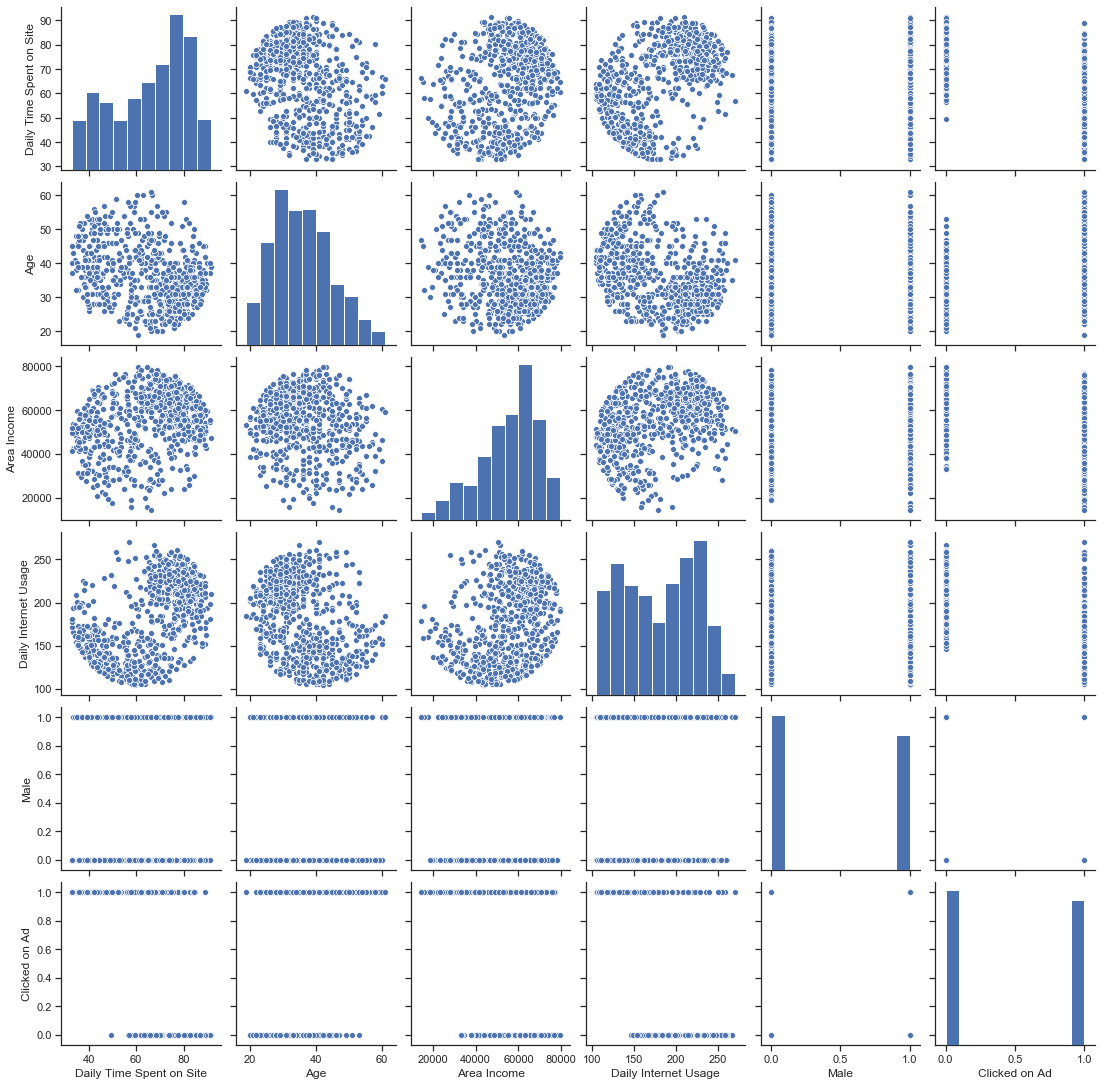

In [19]:
# Парные диаграммы
sns.pairplot(train)

## Построим парные диаграммы, используя целевой признак классификации

За целевой признак для классификации возьмем **"Clicked on Ad"** - переход на сайт рекламодателя 

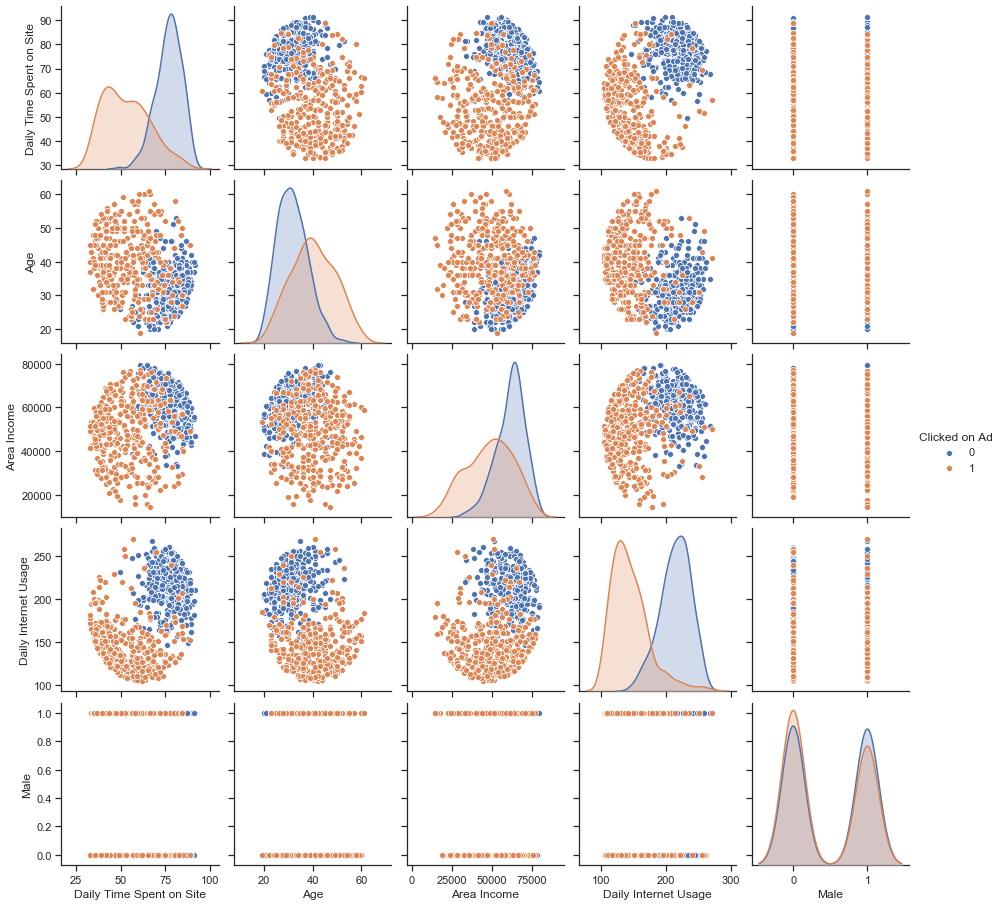

In [20]:
sns.pairplot(train, hue="Clicked on Ad")

**Возможные значения целевого признака классификации в обучающей выборке**

In [21]:
np.sort(train['Clicked on Ad'].unique())

array([0, 1], dtype=int64)

**Возможные значения целевого признака классификации в тестовой выборке**

In [22]:
np.sort(test['Clicked on Ad'].unique())

array([0, 1], dtype=int64)

**Оценка дисбаланса классов для обучающей выборки**

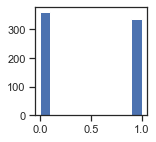

In [23]:
# Оценим дисбаланс классов для Clicked on Ad
fig, ax = plt.subplots(figsize=(2,2)) 
plt.hist(train['Clicked on Ad'])
plt.show()

In [24]:
# Посмотрим, как часто встречается тот или иной целевой признак
train['Clicked on Ad'].value_counts()

0    362
1    338
Name: Clicked on Ad, dtype: int64

In [25]:
# Посчитаем дисбаланс классов
total = train.shape[0]
class_0, class_1 = train['Clicked on Ad'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 51.71%, а класс 1 составляет 48.29%.


**Оценка дисбаланса классов для тестовой выборки**

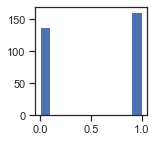

In [26]:
# Оценим дисбаланс классов для Clicked on Ad
fig, ax = plt.subplots(figsize=(2,2)) 
plt.hist(test['Clicked on Ad'])
plt.show()

In [27]:
# Посмотрим, как часто встречается тот или иной целевой признак
test['Clicked on Ad'].value_counts()

1    162
0    138
Name: Clicked on Ad, dtype: int64

In [28]:
# Посчитаем дисбаланс классов
total = test.shape[0]
class_0, class_1 = test['Clicked on Ad'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 54.0%, а класс 1 составляет 46.0%.


## Вывод об оценке дисбаланса классов

**Дисбаланс классов практически отсутствует** 

## Построение скрипичных диаграмм для обучающей выборки

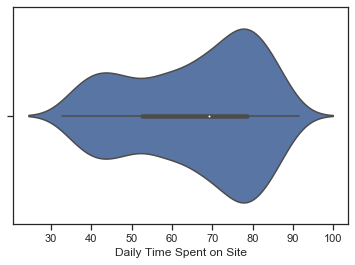

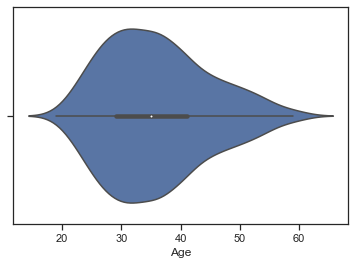

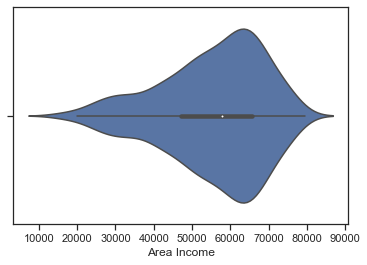

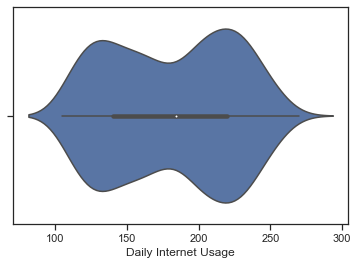

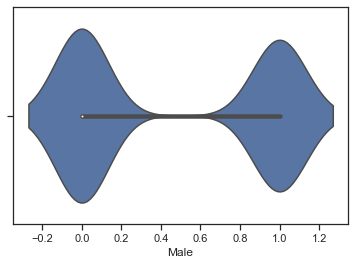

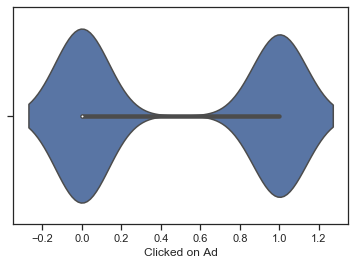

In [32]:
# Скрипичные диаграммы для числовых колонок
for col in ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male', 'Clicked on Ad']:
    sns.violinplot(x=train[col])
    plt.show()

In [33]:
train.dtypes

Daily Time Spent on Site    float64
Age                           int64
Area Income                 float64
Daily Internet Usage        float64
Ad Topic Line                object
City                         object
Male                          int64
Country                      object
Timestamp                    object
Clicked on Ad                 int64
dtype: object

Убираем значения, тип которых не равен float64 и int64

In [34]:
# Создадим вспомогательные колонки, чтобы наборы данных можно было разделить
train['dataset'] = 'TRAIN'
test['dataset'] = 'TEST'

In [35]:
# Колонки для объединения
join_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male', 'Clicked on Ad', 'dataset']

## Склеиваем обучающую и тестовую выборку 

In [36]:
data_all = pd.concat([train[join_cols], test[join_cols]])

In [38]:
# Проверим корректность объединения
assert data_all.shape[0] == train.shape[0]+test.shape[0]

In [39]:
data_all.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,dataset
0,68.95,35,61833.90,256.09,0,0,TRAIN
1,80.23,31,68441.85,193.77,1,0,TRAIN
2,69.47,26,59785.94,236.50,0,0,TRAIN
3,74.15,29,54806.18,245.89,1,0,TRAIN
4,68.37,35,73889.99,225.58,0,0,TRAIN


**Отмасштабируем все признаки кроме целевого**

In [46]:
# Числовые колонки для масштабирования
scale_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male']

In [47]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_all[scale_cols])

In [48]:
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data_all[new_col_name] = sc1_data[:,i]

In [49]:
data_all.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,dataset,Daily Time Spent on Site_scaled,Age_scaled,Area Income_scaled,Daily Internet Usage_scaled,Male_scaled,Clicked on Ad_scaled
0,68.95,35,61833.90,256.09,0,0,TRAIN,0.617882,0.380952,0.730472,0.916031,0.0,0.0
1,80.23,31,68441.85,193.77,1,0,TRAIN,0.809621,0.285714,0.831375,0.538746,1.0,0.0
2,69.47,26,59785.94,236.50,0,0,TRAIN,0.626721,0.166667,0.699200,0.797433,0.0,0.0
3,74.15,29,54806.18,245.89,1,0,TRAIN,0.706272,0.238095,0.623160,0.854280,1.0,0.0
4,68.37,35,73889.99,225.58,0,0,TRAIN,0.608023,0.380952,0.914568,0.731323,0.0,0.0


**Проверим, что масштабирование не повлияло на распределение данных**

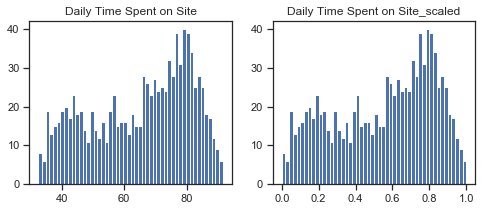

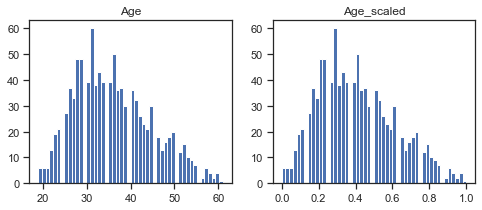

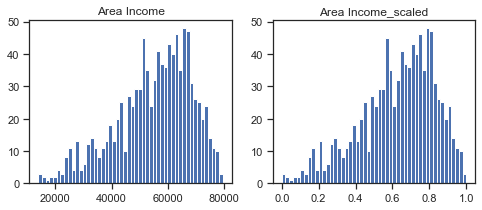

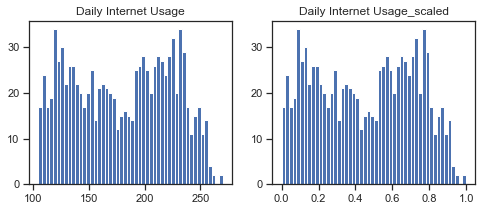

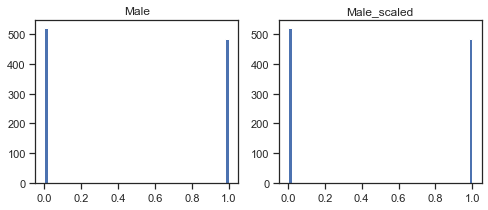

In [50]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data_all[col], 50)
    ax[1].hist(data_all[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

**Вернем в набор данных целевой признак**

In [51]:
corr_cols_1 = scale_cols + ['Clicked on Ad']
corr_cols_1

['Daily Time Spent on Site',
 'Age',
 'Area Income',
 'Daily Internet Usage',
 'Male',
 'Clicked on Ad']

In [52]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['Clicked on Ad']
corr_cols_2

['Daily Time Spent on Site_scaled',
 'Age_scaled',
 'Area Income_scaled',
 'Daily Internet Usage_scaled',
 'Male_scaled',
 'Clicked on Ad']

## Построим корреляционную матрицу для первичных данных

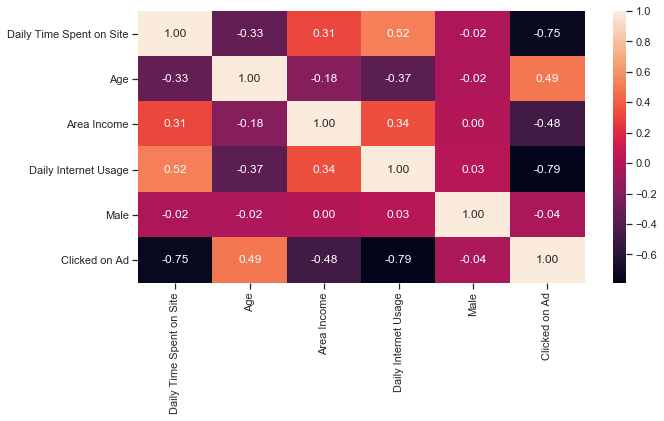

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data_all[corr_cols_1].corr(), annot=True, fmt='.2f')

## Построим корреляционную матрицу для масштабированных данных

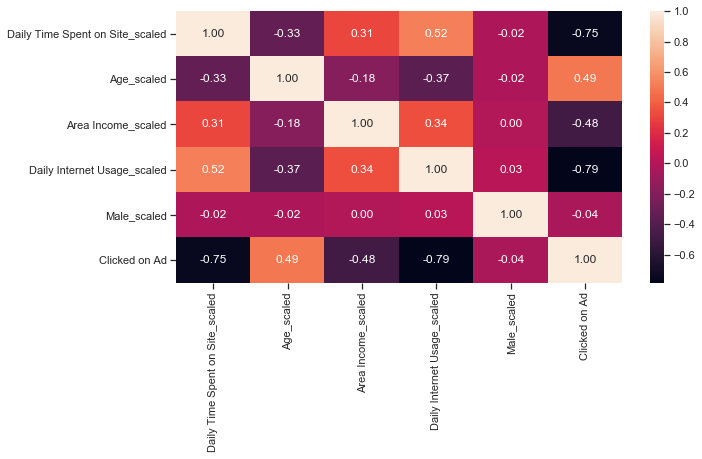

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data_all[corr_cols_2].corr(), annot=True, fmt='.2f')

## Выводы о коррелирующих признаках 

1. Корреляицонные матрицы для исходных и масштабированных данных совпадают 
2. Целевой признак классификации ("Clicked on AD") наиболее сильно коррелирует с "Daily Time Spent on Site" (0.75), "Daily Internet Usage" (0.79), "Age" (0.49), "Area Income" (0.48)
3. Между собой признаки коррелируют не достаточно сильно, чтобы их исключать 
4. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.

## Разработаем класс для визуализации и сохранения меток

In [55]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()  

**Разделим обучающую и тестовую выборку**

Заметим, что данные в этих выборках масштабированные 

In [56]:
# На основе масштабированных данных выделим обучающую и тестовую выборки с помощью фильтра
train_data_all = data_all[data_all['dataset']=='TRAIN']
test_data_all = data_all[data_all['dataset']=='TEST']
train_data_all.shape, test_data_all.shape

((700, 13), (300, 13))

## Задачи классификации и регрессии 

**Выделим признак для задачи классификации**

In [60]:
# Признаки для задачи классификации
task_clas_cols = ['Daily Time Spent on Site_scaled', 'Age_scaled', 
                  'Area Income_scaled', 'Daily Internet Usage_scaled']

**Определим выборки для задачи классификации**

In [61]:
clas_X_train = train_data_all[task_clas_cols]
clas_X_test = test_data_all[task_clas_cols]
clas_Y_train = train_data_all['Clicked on Ad']
clas_Y_test = test_data_all['Clicked on Ad']
clas_X_train.shape, clas_X_test.shape, clas_Y_train.shape, clas_Y_test.shape

((700, 4), (300, 4), (700,), (300,))

**Выделим признак для задачи регрессии**

Целевым признаком будет "Daily Time Spent on Site". 

Для решения задачи регресии возьмем параметры, которые наиболее сильно коррелируют м целевым. К таким признакам относятся: "Clicked on Ad" (0.75), "Daily Internet Usage_scaled" (0.52), "Age_scaled" (0.33), "Area Income_scaled" (0.31)

In [62]:
# Признаки для задачи регресии
task_regr_cols = ['Age_scaled', 'Area Income_scaled',  
                  'Daily Internet Usage_scaled', 'Clicked on Ad']

**Определим выборки для задачи регрессии**

In [63]:
# Выборки для задачи регресии
regr_X_train = train_data_all[task_regr_cols]
regr_X_test = test_data_all[task_regr_cols]
regr_Y_train = train_data_all['Daily Time Spent on Site_scaled']
regr_Y_test = test_data_all['Daily Time Spent on Site_scaled']
regr_X_train.shape, regr_X_test.shape, regr_Y_train.shape, regr_Y_test.shape

((700, 4), (300, 4), (700,), (300,))

**Создадим словарь моделей, которые будем строить**

In [64]:
# Модели
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

In [65]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

**Построим модель класса**

In [66]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(clas_X_train, clas_Y_train)
    Y_pred = model.predict(clas_X_test)
    precision = precision_score(clas_Y_test.values, Y_pred)
    recall = recall_score(clas_Y_test.values, Y_pred)
    f1 = f1_score(clas_Y_test.values, Y_pred)
    roc_auc = roc_auc_score(clas_Y_test.values, Y_pred)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    print('*****************************************************')
    print(model)
    print('*****************************************************')
    draw_roc_curve(clas_Y_test.values, Y_pred)
    
    plot_confusion_matrix(model, clas_X_test, clas_Y_test.values, 
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    plt.show()

*****************************************************
LogisticRegression()
*****************************************************


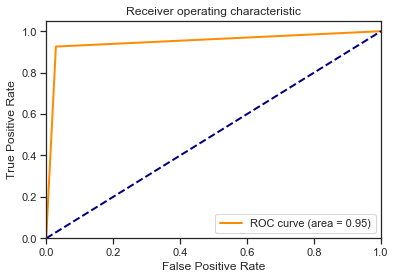

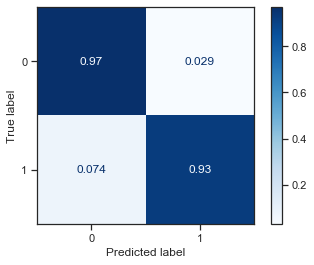

*****************************************************
KNeighborsClassifier()
*****************************************************


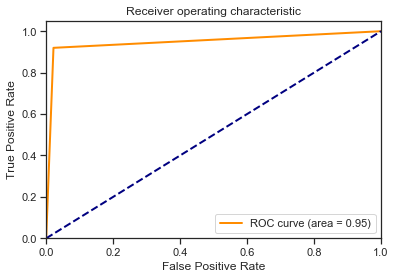

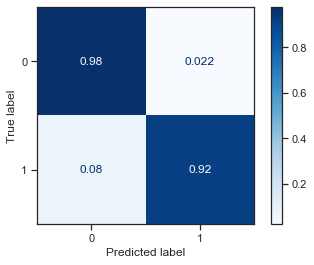

*****************************************************
SVC()
*****************************************************


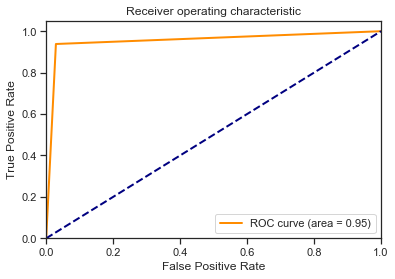

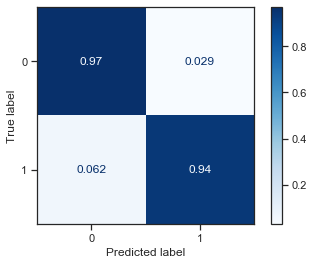

*****************************************************
DecisionTreeClassifier()
*****************************************************


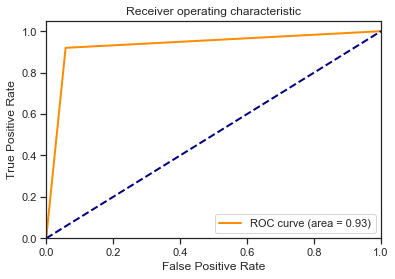

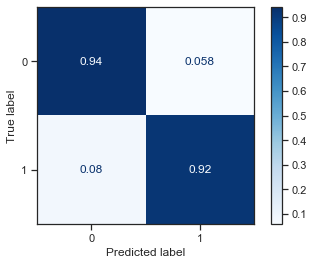

*****************************************************
RandomForestClassifier()
*****************************************************


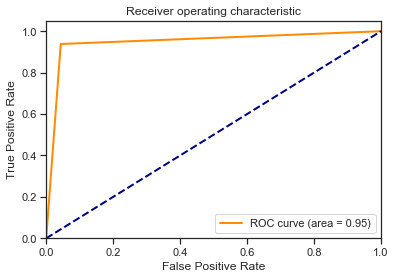

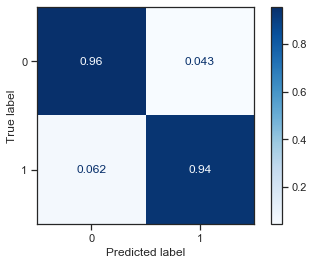

*****************************************************
GradientBoostingClassifier()
*****************************************************


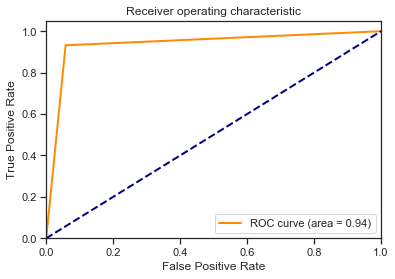

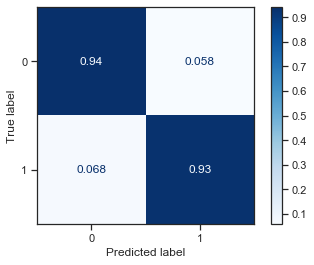

In [67]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

**Создадим словарь моделей, которые будем строить**

In [68]:
# Модели
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [69]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [70]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(regr_X_train, regr_Y_train)
    Y_pred = model.predict(regr_X_test)
    
    mae = mean_absolute_error(regr_Y_test, Y_pred)
    mse = mean_squared_error(regr_Y_test, Y_pred)
    r2 = r2_score(regr_Y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [71]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
LinearRegression()

MAE=0.147, MSE=0.036, R2=0.525
*****************************************************
*****************************************************
KNeighborsRegressor()

MAE=0.098, MSE=0.026, R2=0.661
*****************************************************
*****************************************************
SVR()

MAE=0.097, MSE=0.022, R2=0.708
*****************************************************
*****************************************************
DecisionTreeRegressor()

MAE=0.112, MSE=0.042, R2=0.453
*****************************************************
*****************************************************
RandomForestRegressor()

MAE=0.086, MSE=0.024, R2=0.69
*****************************************************
*****************************************************
GradientBoostingRegressor()

MAE=0.112, MSE=0.026, R2=0.653
*****************************************************


## Подбор гиперпараметров для выбранных моделей

**Пример для задачи классификации**

In [72]:
clas_X_train.shape

(700, 4)

In [130]:
n_range = np.array(range(1,450,10))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
         131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
         261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
         391, 401, 411, 421, 431, 441])}]

In [131]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf_gs.fit(clas_X_train, clas_Y_train)

Wall time: 6 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
       391, 401, 411, 421, 431, 441])}],
             scoring='roc_auc')

In [132]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=271)

In [133]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 271}

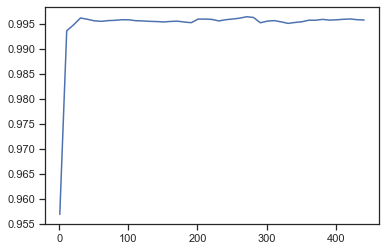

In [134]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

**Пример для задачи регрессии**

In [135]:
n_range = np.array(range(1,450,25))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([  1,  26,  51,  76, 101, 126, 151, 176, 201, 226, 251, 276, 301,
         326, 351, 376, 401, 426])}]

In [136]:
%%time
regr_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(regr_X_train, regr_Y_train)

Wall time: 1.68 s


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([  1,  26,  51,  76, 101, 126, 151, 176, 201, 226, 251, 276, 301,
       326, 351, 376, 401, 426])}],
             scoring='neg_mean_squared_error')

In [137]:
# Лучшая модель
regr_gs.best_estimator_

KNeighborsRegressor(n_neighbors=26)

In [103]:
# Лучшее значение параметров
regr_gs.best_params_

{'n_neighbors': 21}

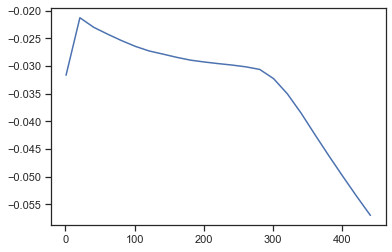

In [104]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, regr_gs.cv_results_['mean_test_score'])

## Сравнение качества исходных моделей с моделями с гиперпараметрами

**Для задачи классификации**

In [116]:
clas_models_grid = {'KNN_271':clf_gs.best_estimator_}

*****************************************************
KNeighborsClassifier(n_neighbors=271)
*****************************************************


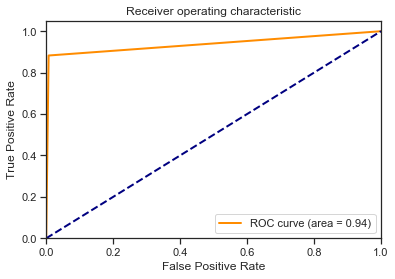

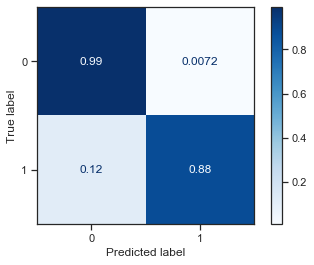

In [117]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

**Для задачи регрессии**

In [91]:
regr_models_grid = {'KNN_26':regr_gs.best_estimator_}

In [92]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
KNeighborsRegressor(n_neighbors=26)

MAE=0.116, MSE=0.027, R2=0.639
*****************************************************


## Выводы о качестве моделей на основе выбранных метрик

**Задача классификации**

In [93]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

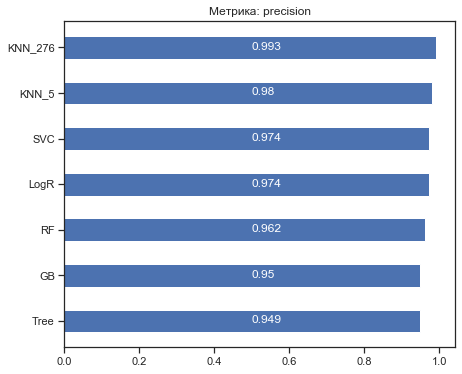

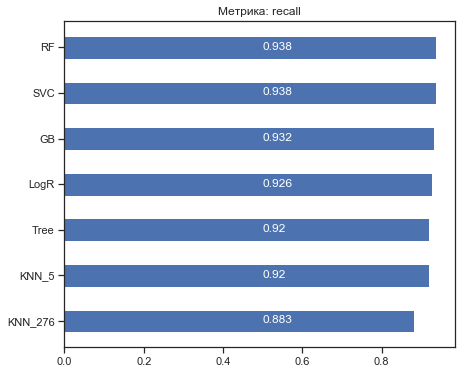

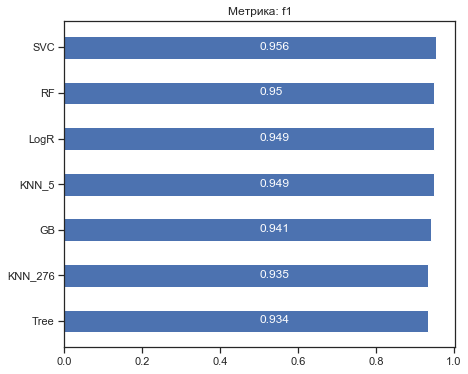

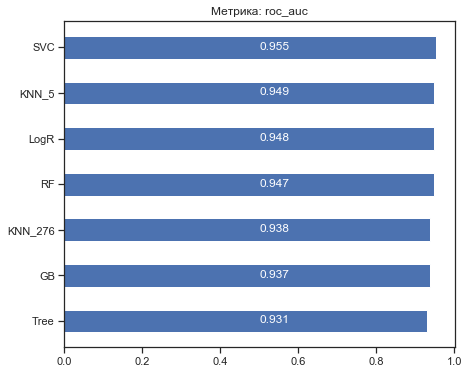

In [94]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

## Вывод

Две из четырех метрики показали, что лучшим является метод опорных векторов (SVC). Однако не для всех метрик данный метод является идеальным.

**Задача регрессии** 

In [95]:
# Метрики качества модели
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

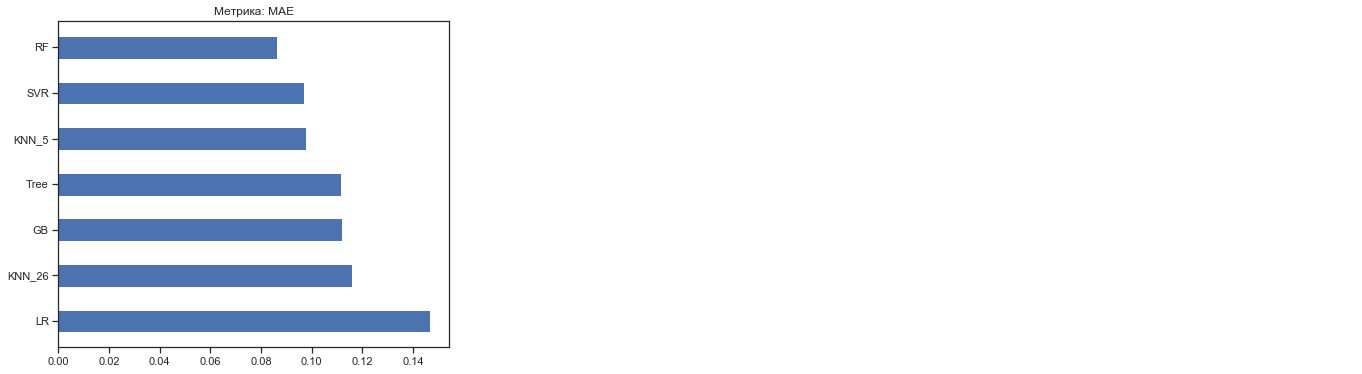

In [96]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

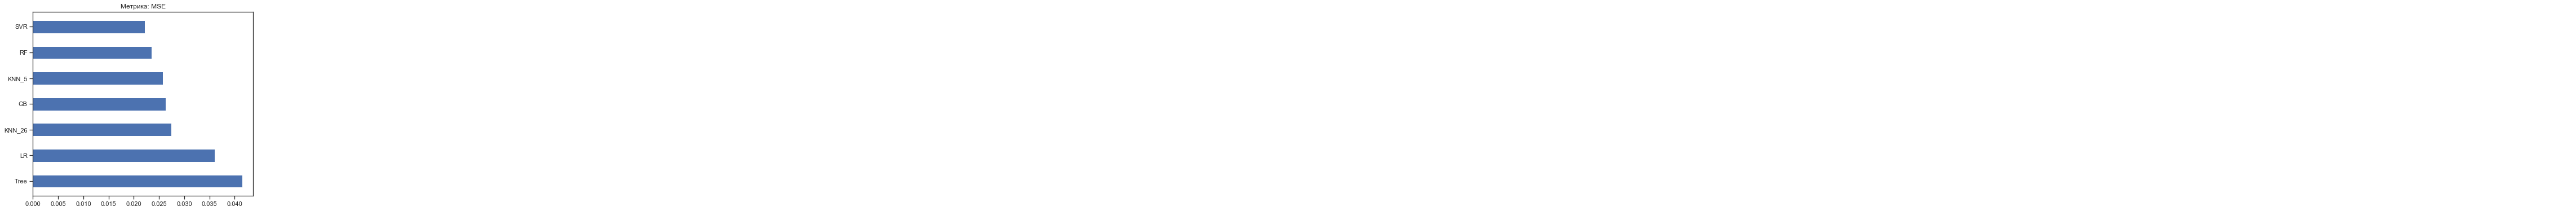

In [98]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

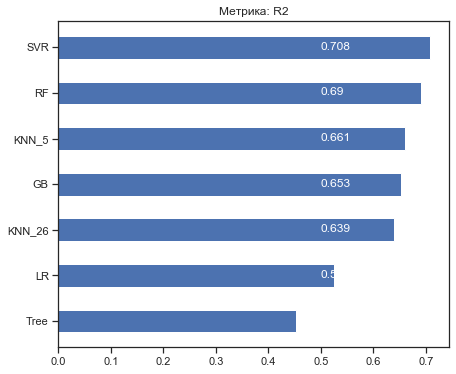

In [99]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

## Вывод

Очень сложно определить наилучший метод, так как для какой-то метрики данный метод идеален, для другой же он совершенно не подходит. Одним из самых подходящих методов является метод к ближайших соседей. 